In [1]:
"""
Establishing baseline embedding / sim search performance with DINOv2
@File    : baseline.ipynb
@Date    : 2026-01-11
@Author  : Nandini Bohra
@Contact : nbohra@ucsd.edu
"""

'\nEstablishing baseline embedding / sim search performance with DINOv2\n@File    : baseline.ipynb\n@Date    : 2026-01-11\n@Author  : Nandini Bohra\n@Contact : nbohra@ucsd.edu\n'

In [10]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pandas import DataFrame
from image_extraction import sample_data


In [16]:
from sklearn.cluster import KMeans

In [ ]:
# Creating list of all catalog images in local directory

base_directory = "/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images"
all_img_files = os.listdir(base_directory)
print(all_img_files)
print(len(all_img_files))


['sample_48.jpg', 'sample_49.jpg', 'sample_05.jpg', 'sample_11.jpg', 'sample_39.jpg', 'sample_38.jpg', 'sample_10.jpg', 'sample_04.jpg', 'sample_12.jpg', 'sample_06.jpg', 'sample_07.jpg', 'sample_13.jpg', 'sample_17.jpg', 'sample_03.jpg', 'sample_02.jpg', 'sample_16.jpg', 'sample_28.jpg', 'sample_00.jpg', 'sample_14.jpg', 'sample_15.jpg', 'sample_01.jpg', 'sample_29.jpg', 'sample_24.jpg', 'sample_30.jpg', 'sample_18.jpg', 'sample_19.jpg', 'sample_31.jpg', 'sample_25.jpg', 'sample_33.jpg', 'sample_27.jpg', 'sample_26.jpg', 'sample_32.jpg', 'sample_36.jpg', 'sample_22.jpg', 'sample_23.jpg', 'sample_37.jpg', 'sample_09.jpg', 'sample_21.jpg', 'sample_35.jpg', 'sample_34.jpg', 'sample_20.jpg', 'sample_08.jpg', 'sample_47.jpg', 'sample_46.jpg', 'sample_44.jpg', 'sample_45.jpg', 'sample_41.jpg', 'sample_40.jpg', 'sample_42.jpg', 'sample_43.jpg']
50


In [3]:
# Creating full paths of all catalog images in local directory

all_img_urls = list(map(lambda x: os.path.join(base_directory, x), all_img_files))
all_img_urls.sort()
all_img_urls[:15]

['/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_00.jpg',
 '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_01.jpg',
 '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_02.jpg',
 '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_03.jpg',
 '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_04.jpg',
 '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_05.jpg',
 '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_06.jpg',

In [ ]:
# Creating dataframe of all images and paths in local directory 

payloads = DataFrame.from_records(
    {"id" : range(0, len(all_img_urls)),
     "image_url": all_img_urls})
payloads["type"] = "samples"
payloads["material"] = payloads["image_url"].map(lambda x: sample_data.get(x, [None, None])[0])
payloads["color"] = payloads["image_url"].map(lambda x: sample_data.get(x, [None, None])[1])

payloads.head()


{'/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_00.jpg': ['JUTE', 'CREAM'], '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_01.jpg': ['AURA', 'ROSE'], '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_02.jpg': ['AURA', 'MINT'], '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_03.jpg': ['SURFACE', 'OFFWHITE'], '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_04.jpg': ['SURFACE', 'COFFEE'], '/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/Product_Catalog/all_product_images/sample_images/sample_05.jpg': ['AURA', 'BROWN'], '/Users/nandinibohra/Desk

,id,image_url,type,material,color
0,0,/Users/nandinibohra/Desktop/VSCodeFiles/ImageR...,samples,JUTE,CREAM
1,1,/Users/nandinibohra/Desktop/VSCodeFiles/ImageR...,samples,AURA,ROSE
2,2,/Users/nandinibohra/Desktop/VSCodeFiles/ImageR...,samples,AURA,MINT
3,3,/Users/nandinibohra/Desktop/VSCodeFiles/ImageR...,samples,SURFACE,OFFWHITE
4,4,/Users/nandinibohra/Desktop/VSCodeFiles/ImageR...,samples,SURFACE,COFFEE


In [ ]:
# Transforming local images into PIL images

images = list(map(lambda x: Image.open(x), payloads["image_url"]))
images[:5]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1700x920>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1700x920>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1700x920>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1700x920>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1700x920>]

In [6]:
# Trying DINO V2 model 
# https://huggingface.co/facebook/dinov2-base

from transformers import AutoImageProcessor, AutoModel
import torch

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.eval()

def get_emb_dinov2(img_path):
    image = Image.open(img_path).convert('RGB')
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Removing CLS Token and taking average of all patch embeddings
    # This is because CLS token is used for classification, semantics and not for image embeddings
    # Proceeding with average of all patch embeddings to retain more fine-grained details of image

    patches = outputs.last_hidden_state[:, 1:, :] # Grab all patch embeddings, no CLS token
    avg_patch_emb = torch.mean(patches, dim=1)

    avg_patch_emb = avg_patch_emb / avg_patch_emb.norm(dim=-1, keepdim=True)

    return avg_patch_emb.squeeze(0).numpy()

/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
embeddings = []
for img_path in payloads["image_url"]:
    emb = get_emb_dinov2(img_path)
    embeddings.append(emb)

embeddings = np.array(embeddings)
print(f"Embeddings shape: {embeddings.shape}")

Embeddings shape: (50, 768)


In [12]:
similarity_matrix = cosine_similarity(embeddings)

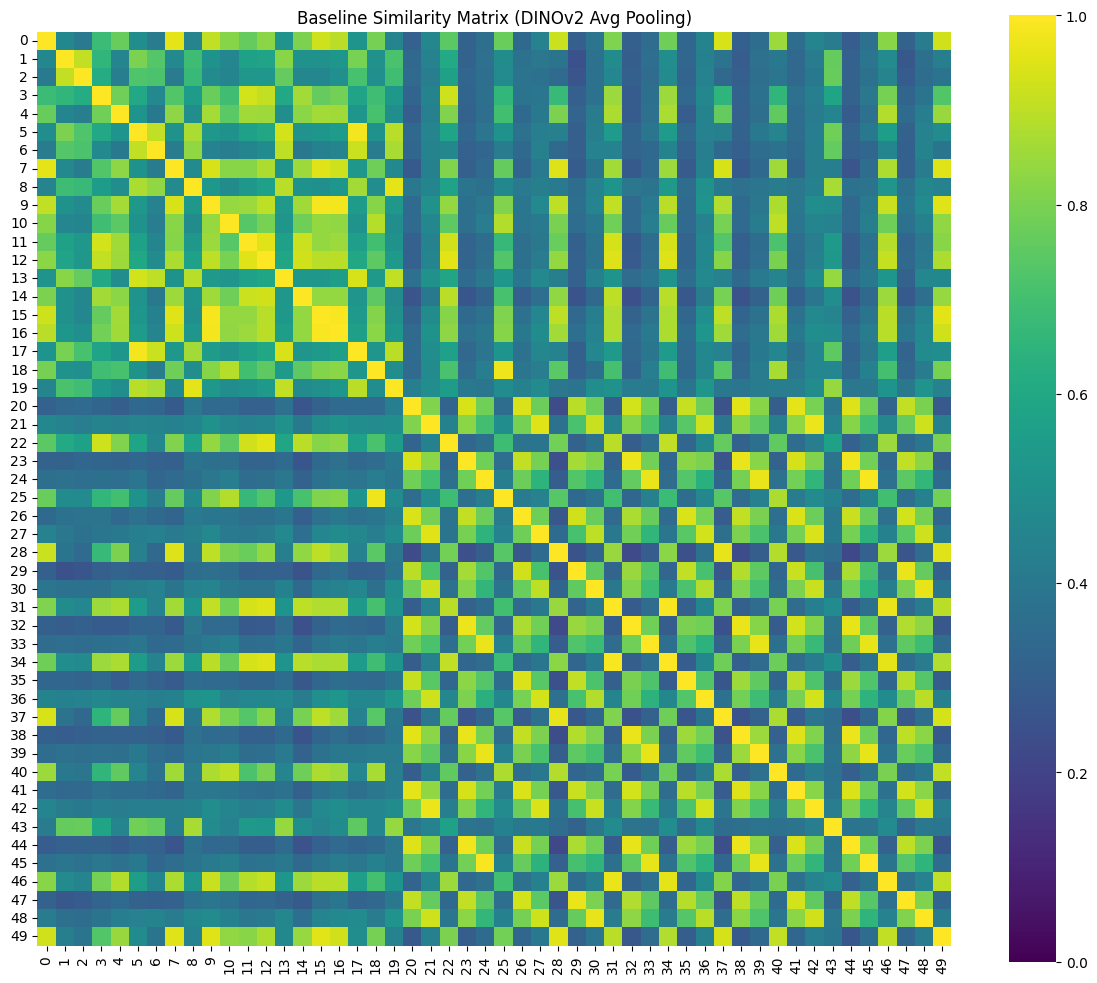

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    similarity_matrix,
    xticklabels=payloads["id"],
    yticklabels=payloads["id"],
    cmap='viridis',
    vmin=0, vmax=1,
    square=True
)
plt.title('Baseline Similarity Matrix (DINOv2 Avg Pooling)')
plt.tight_layout()
plt.savefig('baseline_similarity_matrix.png')
plt.show()


Similarity Statistics:
  Mean: 0.549
  Std:  0.222
  Min:  0.218
  Max:  0.992


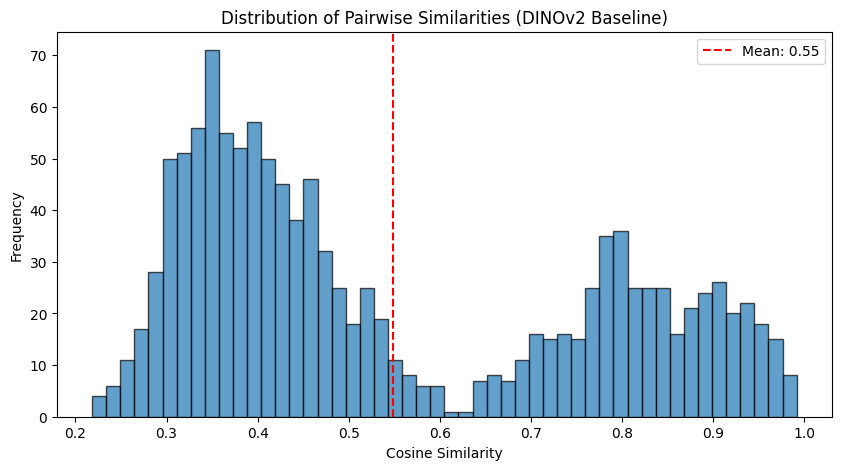

In [15]:
upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
similarities = similarity_matrix[upper_tri_indices]

print("\nSimilarity Statistics:")
print(f"  Mean: {similarities.mean():.3f}")
print(f"  Std:  {similarities.std():.3f}")
print(f"  Min:  {similarities.min():.3f}")
print(f"  Max:  {similarities.max():.3f}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(similarities.mean(), color='red', linestyle='--', label=f'Mean: {similarities.mean():.2f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarities (DINOv2 Baseline)')
plt.legend()
plt.savefig('baseline_distribution.png')
plt.show()

In [17]:
# Trying to understand the bimodal distribution above
# Why certain similarity 'buckets'?
upper_tri = np.triu_indices_from(similarity_matrix, k=1)
similarities = similarity_matrix[upper_tri]
pair_indices = list(zip(upper_tri[0], upper_tri[1]))

# Split into low and high similarity groups
threshold = 0.6  # Adjust based on your histogram valley
low_sim_pairs = [(i, j) for (i, j), sim in zip(pair_indices, similarities) if sim < threshold]
high_sim_pairs = [(i, j) for (i, j), sim in zip(pair_indices, similarities) if sim >= threshold]

print(f"Low similarity pairs (<{threshold}): {len(low_sim_pairs)}")
print(f"High similarity pairs (≥{threshold}): {len(high_sim_pairs)}")

Low similarity pairs (<0.6): 785
High similarity pairs (≥0.6): 440


In [ ]:
materials = payloads["material"]
colors = payloads["color"]

# Check how well color and material matches are in each peak
# Understand reason behind two peaks

def check_metadata_match(pairs, metadata_list, name):
    matches = 0
    for i, j in pairs:
        if metadata_list[i] == metadata_list[j]:
            matches += 1
    
    match_rate = matches / len(pairs) if pairs else 0
    print(f"\n{name} match rate in pairs: {match_rate:.1%}")
    return match_rate

print("LOW SIMILARITY PAIRS (Left peak)")
print("="*50)
low_material_match = check_metadata_match(low_sim_pairs, materials, "Material")
low_color_match = check_metadata_match(low_sim_pairs, colors, "Color")

print()
print()
print("HIGH SIMILARITY PAIRS (Right peak)")
print("="*50)
high_material_match = check_metadata_match(high_sim_pairs, materials, "Material")
high_color_match = check_metadata_match(high_sim_pairs, colors, "Color")


LOW SIMILARITY PAIRS (Left peak)

Material match rate in pairs: 0.0%

Color match rate in pairs: 3.9%


HIGH SIMILARITY PAIRS (Right peak)

Material match rate in pairs: 33.6%

Color match rate in pairs: 6.1%


In [19]:
print("\n" + "="*50)
print("EXAMPLE LOW SIMILARITY PAIRS")
print("="*50)
for i, j in low_sim_pairs[:5]:
    sim = similarity_matrix[i, j]
    print(f"\nPair: {payloads["id"][i]} ↔ {payloads["id"][j]}")
    print(f"  Similarity: {sim:.3f}")
    print(f"  Material: {materials[i]} ↔ {materials[j]}")
    print(f"  Color: {colors[i]} ↔ {colors[j]}")

print("\n" + "="*50)
print("EXAMPLE HIGH SIMILARITY PAIRS")
print("="*50)
for i, j in high_sim_pairs[:5]:
    sim = similarity_matrix[i, j]
    print(f"\nPair: {payloads["id"][i]} ↔ {payloads["id"][j]}")
    print(f"  Similarity: {sim:.3f}")
    print(f"  Material: {materials[i]} ↔ {materials[j]}")
    print(f"  Color: {colors[i]} ↔ {colors[j]}")


EXAMPLE LOW SIMILARITY PAIRS

Pair: 0 ↔ 1
  Similarity: 0.466
  Material: JUTE ↔ AURA
  Color: CREAM ↔ ROSE

Pair: 0 ↔ 2
  Similarity: 0.408
  Material: JUTE ↔ AURA
  Color: CREAM ↔ MINT

Pair: 0 ↔ 5
  Similarity: 0.492
  Material: JUTE ↔ AURA
  Color: CREAM ↔ BROWN

Pair: 0 ↔ 6
  Similarity: 0.418
  Material: JUTE ↔ AURA
  Color: CREAM ↔ PEACOCK

Pair: 0 ↔ 8
  Similarity: 0.451
  Material: JUTE ↔ AURA
  Color: CREAM ↔ BUFF

EXAMPLE HIGH SIMILARITY PAIRS

Pair: 0 ↔ 3
  Similarity: 0.680
  Material: JUTE ↔ SURFACE
  Color: CREAM ↔ OFFWHITE

Pair: 0 ↔ 4
  Similarity: 0.766
  Material: JUTE ↔ SURFACE
  Color: CREAM ↔ COFFEE

Pair: 0 ↔ 7
  Similarity: 0.958
  Material: JUTE ↔ JUTE
  Color: CREAM ↔ MAIZE

Pair: 0 ↔ 9
  Similarity: 0.903
  Material: JUTE ↔ JUTE
  Color: CREAM ↔ OAK

Pair: 0 ↔ 10
  Similarity: 0.817
  Material: JUTE ↔ CHORD
  Color: CREAM ↔ COFFEE
